In [1]:
random_seed = 1
import random
random.seed(random_seed)

import numpy as np
# set the random seed to make the experiment reproducible

np.random.seed(random_seed)

import tensorflow
# set seed
tensorflow.random.set_seed(random_seed)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from keras.utils import np_utils

# imblean provides tools for us to deal with imbalanced class sizes
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import ADASYN

In [3]:
X_train_df = pd.read_excel('data/model_inputs/x_train_5perc.xlsx', index_col=0)
X_test_df = pd.read_excel('data/model_inputs/x_test_5perc.xlsx', index_col=0)
y_train_df = pd.read_excel('data/model_inputs/y_train_5perc.xlsx', index_col=0)
y_test_df = pd.read_excel('data/model_inputs/y_test_5perc.xlsx', index_col=0)

In [4]:
pd.DataFrame(y_train_df.reset_index()).groupby('decision').count()

,index
decision,
-1,30
0,1436
1,45


### Oversampling

In [5]:
def smote(X_train, y_train):
    sm = SMOTE(sampling_strategy='not majority')
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    return X_train_oversampled, y_train_oversampled

def random_oversampler(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    return X_over, y_over

def adasyn(X_train, y_train):
    ada = ADASYN(sampling_strategy = 'not majority')
    X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [6]:
sm = smote(X_train_df, y_train_df)
sm[1].value_counts()

decision
-1          1436
 0          1436
 1          1436
dtype: int64

In [7]:
random_oversampling = random_oversampler(X_train_df, y_train_df)
random_oversampling[1].value_counts()

decision
-1          1436
 0          1436
 1          1436
dtype: int64

In [8]:
ada = adasyn(X_train_df, y_train_df)
ada[1].value_counts()

decision
 1          1449
-1          1446
 0          1436
dtype: int64

### Shuffle + Numpy Array

In [9]:
def shuffle_numpy_encode(X_train, X_test, y_train, y_test):
    # shuffle the dataset! 
    train_data = X_train.copy(deep=True)
    train_data['decision'] = y_train['decision']

    train_data = train_data.sample(frac=1)

    X_train = train_data.drop(['decision'], axis=1)
    y_train = pd.DataFrame(train_data['decision'])

    # convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train = np.array(y_train['decision'])
    y_test = np.array(y_test['decision'])

    # one hot encode
    y_train = np_utils.to_categorical(y_train, num_classes=3)
    y_test = np_utils.to_categorical(y_test, num_classes=3)

    return X_train, X_test, y_train, y_test

In [10]:
def plot_curve(hist):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  epochs = hist.epoch
  f, ax = plt.subplots(ncols=2, figsize=(20,8))
  ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
  ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [11]:
from tabnanny import verbose


def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(input_shape=(X_train_df.shape[1],), units=32, activation='relu')) ### remove flatten code
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    ### change to 3
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="categorical_crossentropy", ### change to non sparse
                metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split, verbose=0)
  
  return history   

### Train Model

In [12]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

In [13]:
results = pd.DataFrame(columns=['loss', 'accuracy', 'recall', 'precision'])

SMOTE Results

In [14]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(sm[0], X_test_df, sm[1], y_test_df)

6/6 [==============================] - 0s 838us/step - loss: 0.8371 - accuracy: 0.8155 - recall: 0.8155 - precision: 0.8155


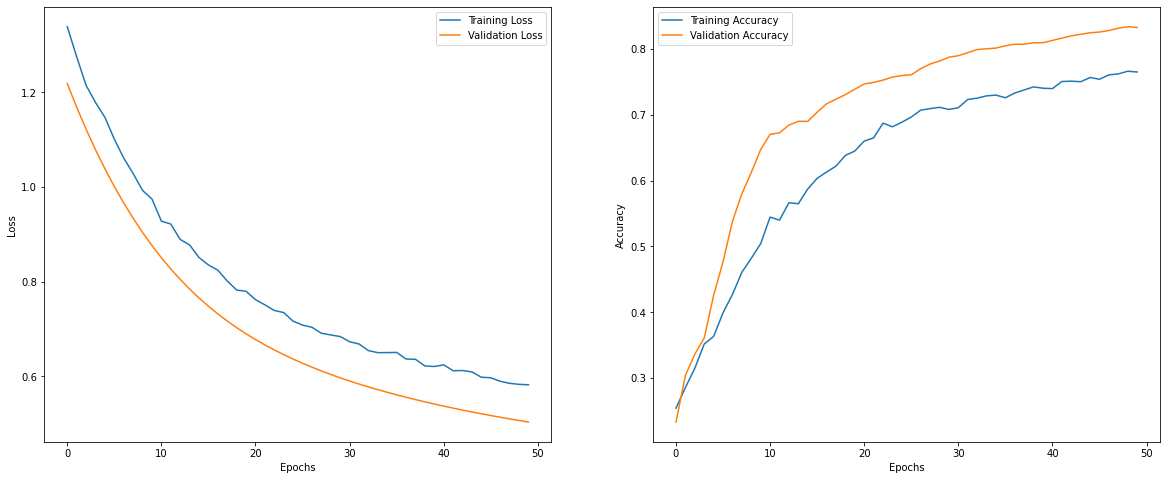

In [15]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['smote'] = list(my_model.evaluate(X_test, y_test))

Random Oversampling Results

In [16]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(random_oversampling[0], X_test_df, random_oversampling[1], y_test_df)

6/6 [==============================] - 0s 857us/step - loss: 0.9869 - accuracy: 0.8155 - recall: 0.8155 - precision: 0.8155


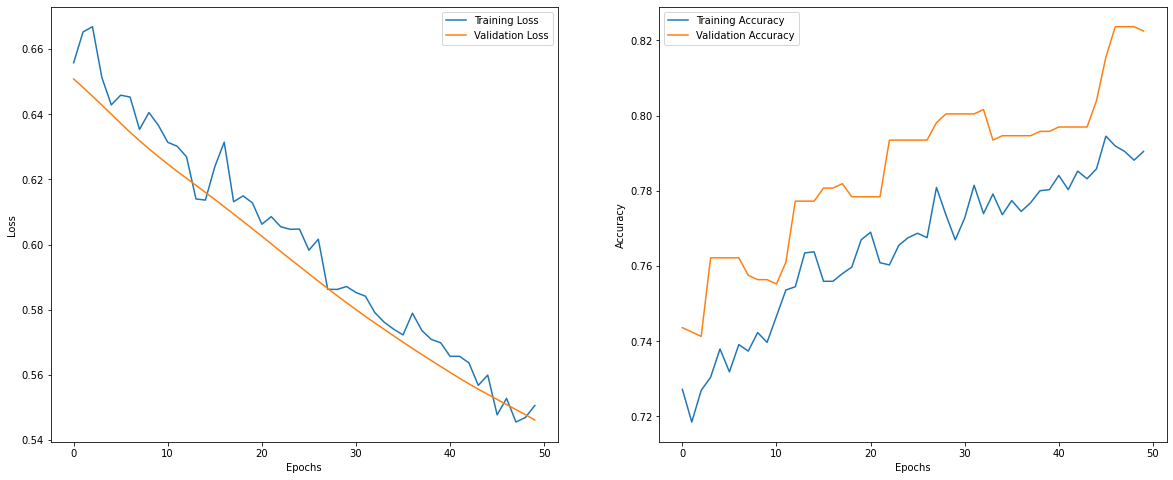

In [17]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['random_oversampling'] = list(my_model.evaluate(X_test, y_test))

ADASYN

In [18]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(ada[0], X_test_df, ada[1], y_test_df)

6/6 [==============================] - 0s 758us/step - loss: 1.5051 - accuracy: 0.8155 - recall: 0.8155 - precision: 0.8155


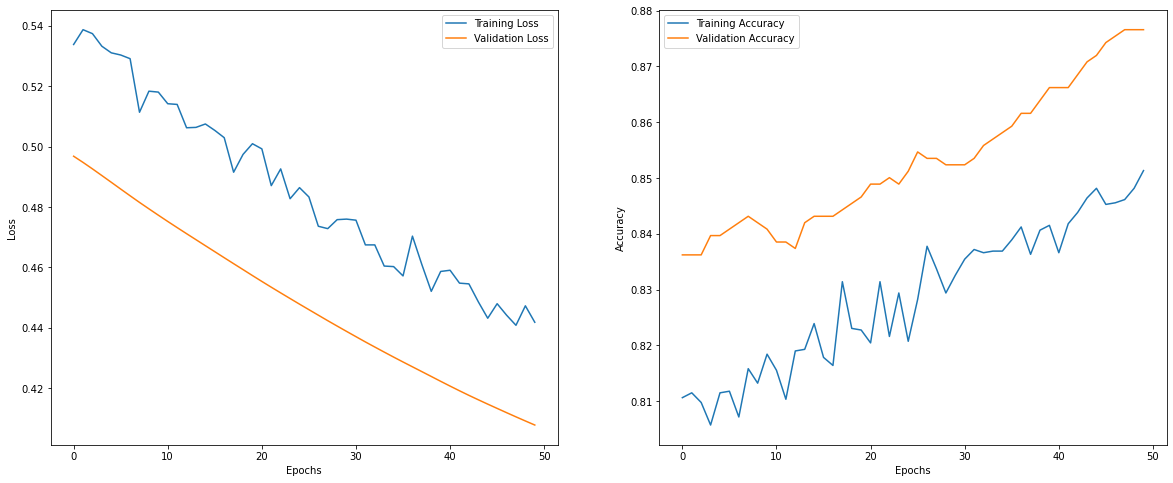

In [19]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['adasyn'] = list(my_model.evaluate(X_test, y_test))

### Results

In [20]:
results # 3 percent

,loss,accuracy,recall,precision
smote,1.060426,0.505952,0.446429,0.503356
random_oversampling,1.021123,0.505952,0.464286,0.513158
adasyn,1.104157,0.500000,0.488095,0.512500


In [20]:
results # 5 percent

,loss,accuracy,recall,precision
smote,0.837102,0.815476,0.815476,0.815476
random_oversampling,0.986858,0.815476,0.815476,0.815476
adasyn,1.505128,0.815476,0.815476,0.815476
